# An intro to Gaussian Processes: Implementing a Basic GP From Scratch

### Introduction

Welcome to this introduction to Gaussian Processes (GPs)! GPs provide some powerful tools for conducting inference, and bring a lot to the table that many other machine learning simply are unable to. Namely, GPs can model complex functions, making them extremely flexible, as well as track our uncertainty at all time.

note: for the purpose of this exercise, when I reference *GPs*, I am specifically talking about 1-D GPs

A GP is completely defined by its mean function (which we will assume to be zero) and its kernel function. For the kernel function, we will implement the basic Squared Exponential Kernel.

### Lets borrow some code

In [1]:
using Random, Distributions, LinearAlgebra, Plots
rng = Random.seed!(09062021) # The date I started this

MersenneTwister(9062021)

### The Data

We will start off by making our toy dataset, by adding some noise to a nonlinear function.

In [2]:
x = range(0,30;length=40)

0.0:0.7692307692307693:30.0

In [3]:
ϵ = rand(Normal(0,0.5), 40);
y = sqrt.(x).*sin.(x) .+ ϵ;

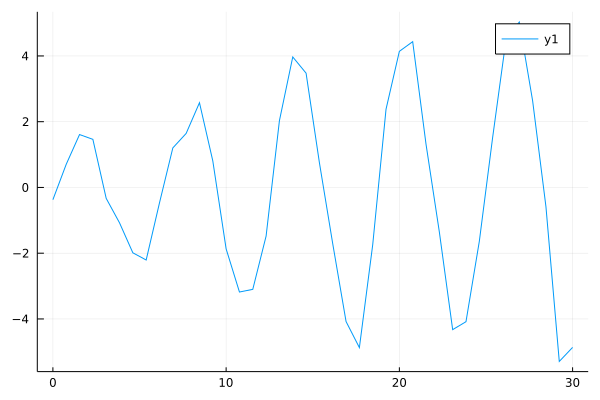

In [4]:
plot(x,y)

In [5]:
indices =  randcycle(rng, 40)
x_train = zeros(30)
y_train = zeros(30)
x_test = zeros(10)
y_test = zeros(10)
for (i, val) in enumerate(indices)
    if i<=30
        x_train[i] = x[val]
        y_train[i] = y[val]
    else
        x_test[i-30] = x[val]
        y_test[i-30] = y[val]
    end
end

We now have split our data to isolate some training data, as well as some unseen data.

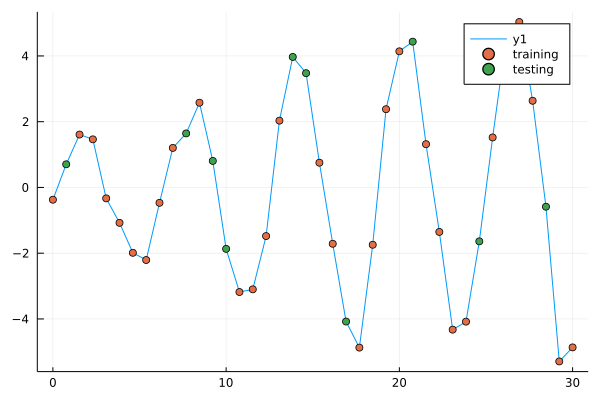

In [6]:
scatter!(x_train ,y_train,label="training")
scatter!(x_test ,y_test,label="testing")

### The Building Blocks

We assume our mean to be zero so all we need to do is build our kernel function that will be used to construct our covariance matrix. As mentioned above we are using the Squared Exponential kernel. This kernel has two parameters, giving our model two hyperparameters. Given this is just a basic intro, we won't be worrying about these.

In [7]:
function SE_kernel(x, x′; σ=1, ℓ=1)
    return (σ^2)*exp(-0.5*(x-x′)^2/ℓ)
end

SE_kernel (generic function with 1 method)

### Define a GP in Julia

In [8]:
struct GP
    # mean = 0
    kernel
end

In [9]:
gp = GP(SE_kernel)

GP(SE_kernel)

### Construct a Covariance Matrix and Cross-Covariance Matrix

While these could very well have just been a single method, I separated them into two to take advantage of the symmetry found in covariance matrices to minimize some computation.

In [10]:
function cov_mat(gp::GP, xs)
    len = length(xs)
    K = zeros(len,len)
    for i in 1:len
        for j in i:len
            K[i,j] = gp.kernel(xs[i],xs[j])
            K[j,i] = K[i,j]
        end
    end
    # we add noise to ensure positive definiteness
    σ = 1e-6
    return K + σ*I
end

cov_mat (generic function with 1 method)

In [11]:
function x_cov_mat(gp::GP, X, X′)
    size= length(X)
    size′= length(X′)
    K =zeros(size,size′)
    for i in 1:size
        for j in 1:size′
            K[i,j] = gp.kernel(X[i],X′[j])
        end
    end
    # we add noise to ensure positive definiteness
    return K
end

x_cov_mat (generic function with 1 method)

### Prior

Here we build a method to draw samples from the prior distribution

In [12]:
function sample_prior(xs, num_samples, gp)
    Σ = cov_mat(gp, xs)
    μ = zeros(length(Σ[1,:]))
    ys = rand(MvNormal(μ, Σ), num_samples)
    plot(xs, ys)
end

sample_prior (generic function with 1 method)

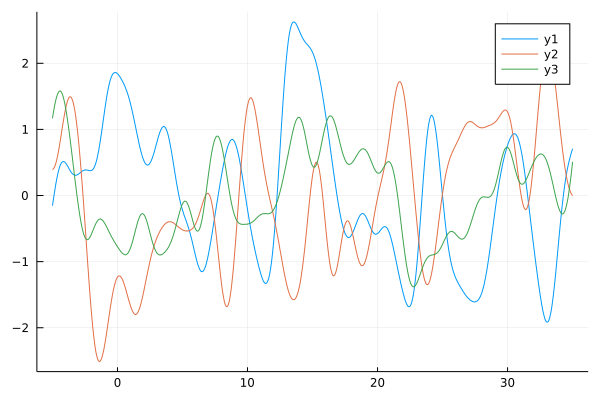

In [13]:
xs = range(-5, 35; length=1000)
sample_prior(xs, 3, gp)

### Posterior

We now build some functionality for computing the posterior gp as well as some other valuable measures.

In [14]:
function posterior(K, y)
    return (1/(det(2*π*K)))*exp((-0.5)*transpose(y)*inv(K)*y)
end

posterior (generic function with 1 method)

In [15]:
function log_pdf(K, y)
    return log(posterior(K, y))
end

log_pdf (generic function with 1 method)

### Posterior GP and sampler

In [16]:
# very naive implementation, will add more efficient methods to compare runtime
function posterior_gp(x_train, y_train, x_pred, gp)
    Σ_11 = cov_mat(gp, x_train)
    Σ_12 = x_cov_mat(gp, x_train, x_pred)
    Σ_22 = cov_mat(gp, x_pred)
    temp = transpose(inv(Σ_11)*Σ_12) # not stable
    μ_post = temp*y_train
    Σ_post = Σ_22 - temp * Σ_12
    return μ_post, Symmetric(Σ_post)
end

posterior_gp (generic function with 1 method)

In [17]:
function sample_posterior(x_train, y_train, x_test, num_samples, gp)
    μ_post, Σ_post = posterior_gp(x_train, y_train, x_test, gp)
    ys = rand(MvNormal(μ_post, Σ_post), num_samples)
    σs = sqrt.(diag(Σ_post))
    return ys, σs
end

sample_posterior (generic function with 1 method)

In [18]:
μ_post, Σ_post = posterior_gp(x_train, y_train, x_test, gp)

([-1.5747827082908494, -4.415673255672966, 3.0873871314585823, 3.735518618327147, 2.6089526100210083, 0.14963093778826253, 2.3005478736957254, 0.8463789374420585, -1.8592430740468586, -1.816004429725153], [0.020758338424372358 0.0015074623998917911 … 4.10277517615824e-5 0.009317649274380096; 0.0015074623998917911 0.033684479358752295 … 0.002502682816173058 0.00028527349176283337; … ; 4.10277517615824e-5 0.002502682816173058 … 0.17791849686419003 7.752571473459711e-6; 0.009317649274380096 0.00028527349176283337 … 7.752571473459711e-6 0.03415397182022484])

In [19]:
x_pred = range(-5, 35; length=1000)
y_pred, σ_pred = sample_posterior(x_train, y_train, x_pred, 3, gp)

([-0.5789701652678456 -0.38950638809889315 0.2739388493857376; -0.49956379030341597 -0.3886645560252907 0.2810599066105757; … ; -1.650184647426752 0.6574610124990421 -0.2776295072990068; -1.6308826312819307 0.715564264636542 -0.2966445049547545], [1.0000004999910181, 1.0000004999866783, 1.000000499980275, 1.0000004999708574, 1.0000004999570529, 1.000000499936883, 1.00000049990751, 1.000000499864874, 1.000000499803189, 1.0000004997142367  …  1.0000004994420857, 1.000000499615375, 1.0000004997356857, 1.000000499818938, 1.000000499876356, 1.0000004999158258, 1.000000499942868, 1.0000004999613346, 1.0000004999739032, 1.0000004999824295])

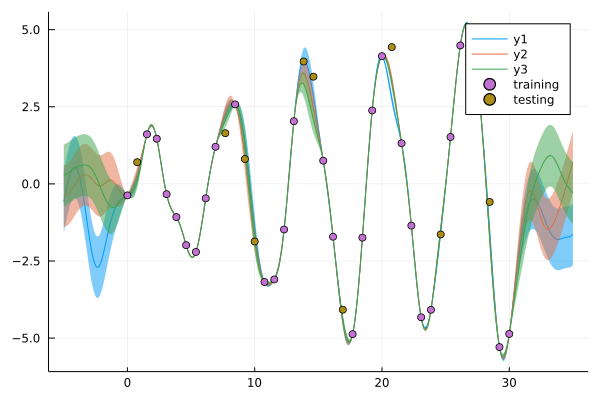

In [20]:
plot(x_pred, y_pred, ribbon=σ_pred)
scatter!(x_train ,y_train,label="training")
scatter!(x_test ,y_test,label="testing")

### Trying a different (and much more quickly varying) target function

We edit the (hardcoded) hyperparameters of our kernel function to better match our assumptions/knowledge about the function we are trying to model.

In [21]:
function SE_kernel_2(x, x′; σ=1, ℓ=0.001)
    return (σ^2)*exp(-0.5*(x-x′)^2/ℓ)
end

SE_kernel_2 (generic function with 1 method)

In [22]:
gp_2 = GP(SE_kernel_2)

GP(SE_kernel_2)

In [23]:
x = range(0,1;length=40)

0.0:0.02564102564102564:1.0

In [24]:
ϵ = rand(Normal(0,0.5), 40);
y = ℯ.^(x) - 3*tan.(x) .+ ϵ;

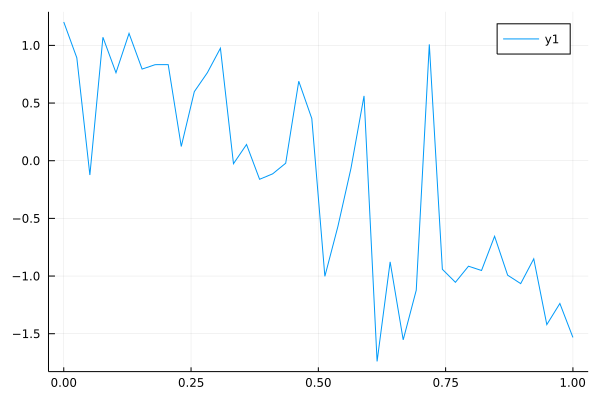

In [25]:
plot(x,y)

In [26]:
indices =  randcycle(rng, 40)
x_train = zeros(30)
y_train = zeros(30)
x_test = zeros(10)
y_test = zeros(10)
for (i, val) in enumerate(indices)
    if i<=30
        x_train[i] = x[val]
        y_train[i] = y[val]
    else
        x_test[i-30] = x[val]
        y_test[i-30] = y[val]
    end
end

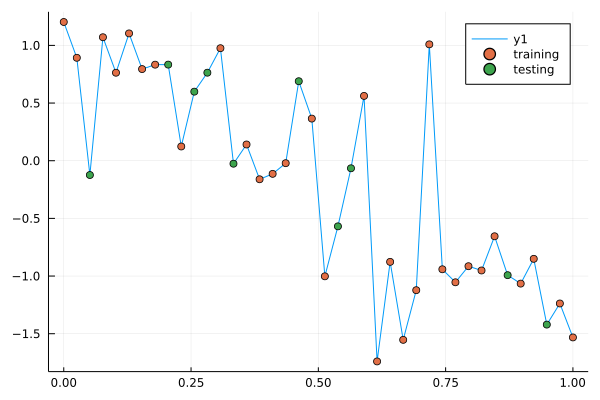

In [27]:
scatter!(x_train ,y_train,label="training")
scatter!(x_test ,y_test,label="testing")

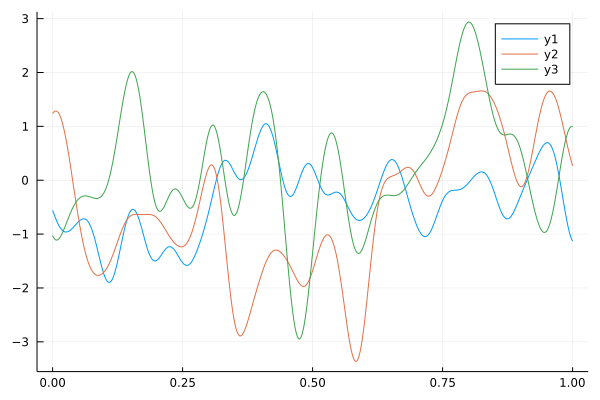

In [28]:
xs = range(0,1;length=1000)
sample_prior(xs,3,gp_2)

In [29]:
μ_post, Σ_post = posterior_gp(x_train, y_train, x_test, gp_2)

([1.7568864935947963, 0.6043235839153737, 0.8098862861375891, -0.8382171930388741, 1.1883063662931745, 0.7673623831314502, -0.002759467255639636, -1.0610537400585218, 0.5451915330248571, -0.30708196682843364], [0.19692591782124513 0.029910777557730788 … -0.002481380596329786 0.19693386255994405; 0.029910777557730788 0.05335037592746272 … -0.011567467517840537 0.056364914988054876; … ; -0.002481380596329786 -0.011567467517840537 … 0.37833601528470406 -0.005165200316895585; 0.19693386255994405 0.056364914988054876 … -0.005165200316895585 0.24103229692678996])

In [30]:
x_pred = range(0, 1; length=1000)
y_pred, σ_pred = sample_posterior(x_train, y_train, x_pred, 3, gp_2)

([1.1992105652409082 1.2030274513142287 1.2031361742462963; 1.1835167701983456 1.2077360975899576 1.2098928242277278; … ; -1.5199610682000317 -1.5112520218983663 -1.5250793558218845; -1.5324322593027262 -1.5321545713717355 -1.5328135337589721], [0.0014142127516367027, 0.014992794780615345, 0.028738142489872623, 0.04131242913634913, 0.052662915328140665, 0.06275520412410887, 0.07156284387103001, 0.07906604132171134, 0.0852514884851951, 0.09011240803771549  …  0.09293625500971221, 0.08781182418360645, 0.08134125260790787, 0.07353547844768943, 0.0644117907889208, 0.05399376336923897, 0.042311404499025936, 0.029402399877694333, 0.015322281933554224, 0.0014142127691039912])

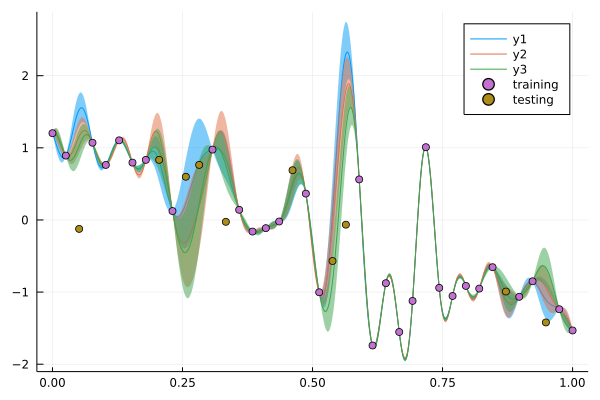

In [31]:
plot(x_pred, y_pred, ribbon=σ_pred)
scatter!(x_train ,y_train,label="training")
scatter!(x_test ,y_test,label="testing")